# Анализ продвижения приложения Procrastinate Pro+

## Описание проекта
Несмотря на огромные вложения в рекламу, последние несколько месяцев компания терпит убытки. Задача — разобраться в причинах и помочь компании выйти в плюс.\
Есть данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года:
- лог сервера с данными об их посещениях,
- выгрузка их покупок за этот период,
- рекламные расходы.

**Основные задачи для анализа:**
- выяснить, откуда приходят пользователи и какими устройствами они пользуются,
- проанализировать, сколько стоит привлечение пользователей из различных рекламных каналов;
- понять, сколько денег приносит каждый клиент,
- выяснить, когда расходы на привлечение клиента окупаются,
- определить, какие факторы мешают привлечению клиентов.

### Загрузка данных и подготовка их к анализу

In [1]:
#импортируем бибилиотеки
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import numpy as np

In [2]:
#загружаем данные из файлов в датафреймы
visits,orders, costs = (
    pd.read_csv('datasets/visits_info_short.csv'),
    pd.read_csv('datasets/orders_info_short.csv'),
    pd.read_csv('datasets/costs_info_short.csv')
)

Изучим и проанализируем данные в каждой из таблиц и выполним необходимую предобработку

In [3]:
visits.head(10)

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40
5,90242400005,United States,iPhone,RocketSuperAds,2019-05-01 07:14:52,2019-05-01 08:19:56
6,43958116050,United States,Android,organic,2019-05-01 09:03:21,2019-05-01 10:08:39
7,185365244969,United States,iPhone,organic,2019-05-01 09:37:03,2019-05-01 10:00:43
8,446013509831,United States,iPhone,RocketSuperAds,2019-05-01 10:26:00,2019-05-01 10:59:17
9,100970711362,United States,Mac,TipTop,2019-05-01 04:39:53,2019-05-01 04:57:05


В таблице представлены данные о пользовательских сессиях. Здесь представлен ID пользователя, регион пользователя, устройство, с которого пользователь выходил, канал привлечения, а также начало и окончание сессии.\
Рассмотрим основную информацию о датафрейме

In [4]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


Всего в таблице 309901 строка. Датафрейм содержит 6 столбцов с данными. Пропусков нет. 5 столбцов содержат тип данных 'object', 1 - целочисленный.\
Необходимо переименовать ряд столбцов (перевести в нижний регистр и вставить нижнее подчеркивание), а также изменить тип данных для столбцов с началом и окончанием сессии на datetime.

In [5]:
#переименовываем столбцы и приводим их к нижнему регистру
visits = visits.rename(columns = {'User Id': 'user_id', 'Session Start': 'session_start', 'Session End': 'session_end'})
visits.columns = visits.columns.str.lower()
# изменяем тип данных
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
# Посмотрим результат
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB


Изучим датафрейм на наличие явных и неявных дубликатов

In [6]:
visits.duplicated().sum()

0

In [7]:
visits['region'].unique()

array(['United States', 'UK', 'France', 'Germany'], dtype=object)

In [8]:
visits['device'].unique()

array(['iPhone', 'Mac', 'Android', 'PC'], dtype=object)

In [9]:
visits['channel'].unique()

array(['organic', 'TipTop', 'RocketSuperAds', 'YRabbit', 'FaceBoom',
       'MediaTornado', 'AdNonSense', 'LeapBob', 'WahooNetBanner',
       'OppleCreativeMedia', 'lambdaMediaAds'], dtype=object)

Явных и неявных дубликатов не обнаружено\
Таким образом, первая таблица готова к исследовательскому анализу

Рассмотрим данные, представленные в таблице с заказами

In [10]:
orders.head(10)

,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99
5,129100331057,2019-05-01 01:56:28,4.99
6,626807144131,2019-05-01 02:39:21,4.99
7,914062168985,2019-05-01 02:02:18,4.99
8,769669137453,2019-05-01 03:39:47,4.99
9,434198630691,2019-05-01 18:16:50,5.99


В представленной таблице три столбца: данные по ID пользователя, дата покупки и сумма покупки.\
Видна необходимость в переименовании столбцов.\
Также рассмотрим основную информацию о таблице

In [11]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


Всего в таблице 40212 строк. Датафрейм содержит 3 столбца с данными. Пропусков нет. 
Необходимо переименовать ряд столбцов (перевести в нижний регистр и вставить нижнее подчеркивание), а также изменить тип данных для столбца 'Event Dt' на datetime.

In [12]:
#переименовываем столбцы и приводим их к нижнему регистру
orders = orders.rename(columns = {'User Id': 'user_id', 'Event Dt': 'event_dt', 'Revenue': 'revenue'})
# Изменяем тип данных
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
# Смотрим на результат предобработки
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   40212 non-null  int64         
 1   event_dt  40212 non-null  datetime64[ns]
 2   revenue   40212 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 942.6 KB


In [13]:
#изучим числовые данные датасета на наличие аномалий
orders.describe()

,user_id,revenue
count,4.021200e+04,40212.000000
mean,4.990295e+11,5.370608
std,2.860937e+11,3.454208
min,5.993260e+05,4.990000
25%,2.511324e+11,4.990000
50%,4.982840e+11,4.990000
75%,7.433327e+11,4.990000
max,9.998954e+11,49.990000


Отрицательных и нулевых значений в столбце со стоимостью заказа нет

Изучим датафрейм на наличие явных дубликатов

In [14]:
orders.duplicated().sum()

0

Явных дубликатов не обнаружено\
Таким образом, таблица с информацией о заказах готова к исследовательскому анализу

Проведем аналогичную работу с таблицей, содержащей информацию о тратах на рекламу

In [15]:
costs.head(10)

,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1
5,2019-05-06,FaceBoom,118.8
6,2019-05-07,FaceBoom,101.2
7,2019-05-08,FaceBoom,100.1
8,2019-05-09,FaceBoom,93.5
9,2019-05-10,FaceBoom,104.5


В представленной таблице три столбца: данные о дате, канале и сумме затрат.\
Видна необходимость в изменении регистра столбцов.\
Рассмотрим основную информацию по таблице

In [16]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


Всего в таблице 1800 строк. Датафрейм содержит 3 столбца с данными. Пропусков нет. 
Необходимо изменить тип данных для столбца 'dt' на datetime.

In [17]:
# изменяем регистр в наименовании столбцов на нижний
costs.columns = costs.columns.str.lower()
#  изменяем тип данных для столбца с датой
costs['dt'] = pd.to_datetime(costs['dt'])
# проверяем внесенные изменения
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   dt       1800 non-null   datetime64[ns]
 1   channel  1800 non-null   object        
 2   costs    1800 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 42.3+ KB


Проверим таблицу на наличие явных и неявных дубликатов

In [18]:
costs.duplicated().sum()

0

In [19]:
costs['channel'].unique()

array(['FaceBoom', 'MediaTornado', 'RocketSuperAds', 'TipTop', 'YRabbit',
       'AdNonSense', 'LeapBob', 'OppleCreativeMedia', 'WahooNetBanner',
       'lambdaMediaAds'], dtype=object)

Явных и неявных дубликатов не обнаружено

In [20]:
#изучим числовые данные датасета на наличие аномалий
costs.describe()

,costs
count,1800.000000
mean,58.609611
std,107.740223
min,0.800000
25%,6.495000
50%,12.285000
75%,33.600000
max,630.000000


Никаких числовых аномалий не наблюдается
Таблица с информацией о затратах на маркетинг готова к исследовательскому анализу.\
Таким образом, мы провели предобработку данных в представленных таблицах и подготовили их к последующему анализу.

### Задайте функции для расчёта и анализа LTV, ROI, удержания и конверсии.

Разрешается использовать функции, с которыми вы познакомились в теоретических уроках.

Это функции для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

А также функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

In [21]:
# функция для создания пользовательских профилей

def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['dt'] = pd.to_datetime(profiles['dt'], format="%Y-%m-%d")
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())


    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )
    
    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    # результаты сохраним в столбец acquisition_cost (CAC)
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

In [22]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [23]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [24]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

In [25]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

In [26]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 

In [27]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [28]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

### Исследовательский анализ данных

- Составьте профили пользователей. Определите минимальную и максимальную даты привлечения пользователей.

In [29]:
#используем функцию get_profiles для создания таблицы профилей и выводим 5 строк на экран
profiles = get_profiles(visits, orders, costs)
profiles.head()

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


In [30]:
#определяем минимальную дату привлечения пользователей
min_date = profiles['dt'].min()
min_date

Timestamp('2019-05-01 00:00:00')

In [31]:
#определяем максимальную дату привлечения пользователей
max_date = profiles['dt'].max()
max_date

Timestamp('2019-10-27 00:00:00')

Таким образом, минимальная дата привлечения - 01 мая 2019 года, максимальная - 27 октября 2019 года, что соответствует техническому заданию (нам предоставлены данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года)

- Выясните, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Постройте таблицу, отражающую количество пользователей и долю платящих из каждой страны.

In [32]:
#посчитаем количество пользователей из каждой страны
profiles['region'].value_counts()

United States    100002
UK                17575
France            17450
Germany           14981
Name: region, dtype: int64

Подавляющее большинство пользователей приложения из США, примерно поровну - из Великобритании и Франции, и меньше всего - из Германии.

In [33]:
#создадим таблицу, в которой сведем вместе общее число пользователей в разных странах, 
#число платящих пользователей и долю платящих среди всех пользователей по каждой стране
region_payer = pd.DataFrame()
region_payer['users_total'] = profiles.groupby('region')['user_id'].count()
region_payer['payer_total'] = profiles.query('payer == True').groupby('region')['user_id'].count()
region_payer['share_%'] = region_payer['payer_total'] / region_payer['users_total']*100
#выведем на экран по убыванию доли платящих пользователей
region_payer.sort_values(by='share_%', ascending=False)

,users_total,payer_total,share_%
region,,,
United States,100002,6902,6.901862
Germany,14981,616,4.111875
UK,17575,700,3.982930
France,17450,663,3.799427


Из таблицы видно, что больше всего платящих пользователей находятся в США -6902, что составляет почти 7% от общего числа пользователей из этой страны. Затем примерно в равной степени идут пользователи из Германии (4,1%), Великобритании(4%) и Франции (3,8%).

- Узнайте, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Постройте таблицу, отражающую количество пользователей и долю платящих для каждого устройства

In [34]:
profiles['device'].value_counts()

iPhone     54479
Android    35032
PC         30455
Mac        30042
Name: device, dtype: int64

Среди устройств, которыми пользуются клиенты, на первом месте по числу всех клиентов - iPhone, на втором месте - пользователи Android, и примерно одинаковое число среди пользователей PC и Mac.

In [35]:
#создадим таблицу, в которой сведем вместе общее число пользователей, 
#число платящих пользователей и долю платящих среди всех пользователей по каждому типу устройства
device_payer = pd.DataFrame()
device_payer['users_total'] = profiles.groupby('device')['user_id'].count()
device_payer['payer_total'] = profiles.query('payer == True').groupby('device')['user_id'].count()
device_payer['share_%'] = device_payer['payer_total'] / device_payer['users_total']*100
device_payer.sort_values(by='share_%', ascending=False)

,users_total,payer_total,share_%
device,,,
Mac,30042,1912,6.364423
iPhone,54479,3382,6.207897
Android,35032,2050,5.851793
PC,30455,1537,5.046790


Здесь можно увидеть следующую картину: самое большое число платящих клиентов характерно для пользователей Mac (6.4%), на втором месте - владельцы iPhone (6,2%), затем идут пользователи Android (5,9%) и, наконец, PC (5%).

- Изучите рекламные источники привлечения и определите каналы, из которых пришло больше всего платящих пользователей. Постройте таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения

In [36]:
#изучим источники привлечения
profiles['channel'].unique()

array(['FaceBoom', 'organic', 'AdNonSense', 'YRabbit', 'MediaTornado',
       'RocketSuperAds', 'LeapBob', 'TipTop', 'WahooNetBanner',
       'OppleCreativeMedia', 'lambdaMediaAds'], dtype=object)

Построим таблицу, в которой отразим общее число пользователей, пришедших из разных каналов, число и долю платящих пользователей по всем каналам.

In [37]:
#создадим таблицу, в которой сведем вместе общее число пользователей, 
#число платящих пользователей и долю платящих среди всех пользователей по каждому каналу продвижения
channel_payer = pd.DataFrame()
channel_payer['users_total'] = profiles.groupby('channel')['user_id'].count()
channel_payer['payer_total'] = profiles.query('payer == True').groupby('channel')['user_id'].count()
channel_payer['share_%'] = channel_payer['payer_total'] / channel_payer['users_total']*100
channel_payer.sort_values(by='share_%', ascending=False)

,users_total,payer_total,share_%
channel,,,
FaceBoom,29144,3557,12.204914
AdNonSense,3880,440,11.340206
lambdaMediaAds,2149,225,10.469986
TipTop,19561,1878,9.600736
RocketSuperAds,4448,352,7.913669
WahooNetBanner,8553,453,5.296387
YRabbit,4312,165,3.826531
MediaTornado,4364,156,3.574702
LeapBob,8553,262,3.063253


Судя по таблице, больше всего пользователей пришли из канала 'organic', при этом конверсия их в платящих минимальная - всего 2% становятся покупателями. Самый большой показатель по платящим у канала 'FaceBoom', на втором и третьем месте AdNonSense и lambdaMediaAds, хотя общее число пользователей, пришедших из этого канала невелика. Также достаточно большой процент платящих пользователей у канала 'TipTop'- 9,6%.

### Маркетинг

- Посчитайте общую сумму расходов на маркетинг.

In [38]:
round(costs['costs'].sum(),1)

105497.3

В общей сложности расходы на маркетинговое продвижение составили чуть больше 105 тысяч.

- Выясните, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.

In [39]:
#создаем сводную таблицу, в которой по каждому каналу рассчитаем общее число расходови
channel_sum = costs.pivot_table(index = 'channel', values = 'costs', aggfunc = 'sum').sort_values(by='costs', ascending=False)
channel_sum

,costs
channel,
TipTop,54751.30
FaceBoom,32445.60
WahooNetBanner,5151.00
AdNonSense,3911.25
OppleCreativeMedia,2151.25
RocketSuperAds,1833.00
LeapBob,1797.60
lambdaMediaAds,1557.60
MediaTornado,954.48


Из таблицы видно, что примерно половина всех расходов приходится на 'TipTop'- больше 50 тысяч. Также достаточно много вкладывается в канал 'FaceBoom' - более 32 тысяч. Во всех остальных каналах продвижения расходы невелики - от 5000 на 'WahooNetBanner' до 944 на 'YRabbit'.

- Постройте визуализацию динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику. Постарайтесь отразить это на одном графике.

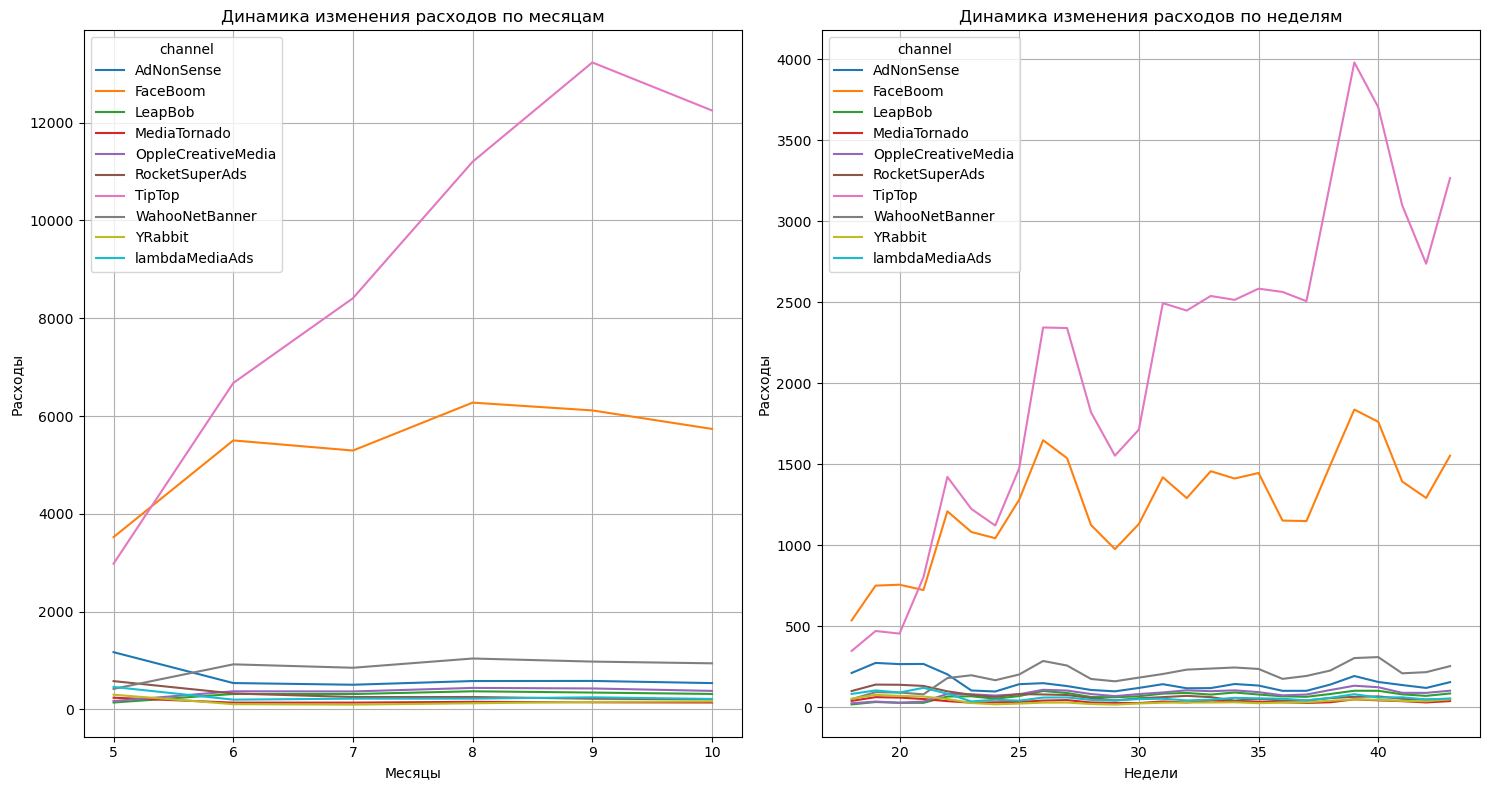

In [40]:
#добавим в таблицу costs два новых столбца - с номером месяца и номером недели
costs['month'] = costs['dt'].dt.month
costs['week'] = costs['dt'].dt.isocalendar().week
#создадим две сводные таблицы, в которых в динамике по месяцам/неделям рассчитаем затраты по каждому каналу привлечения
costs_new_month = costs.pivot_table(index = 'month', columns = 'channel', values = 'costs', aggfunc = 'sum')
costs_new_week = costs.pivot_table(index = 'week', columns = 'channel', values = 'costs', aggfunc = 'sum')
#построим по сводным таблицам рядом два линейных графика
plt.figure(figsize=(15, 8))
ax1 = plt.subplot(1, 2, 1)
costs_new_month.plot(grid=True, ax=ax1)
plt.xlabel('Месяцы')
plt.ylabel('Расходы')
plt.title('Динамика изменения расходов по месяцам')
ax2 = plt.subplot(1, 2, 2)#, sharey=ax1)
costs_new_week.plot(grid=True, ax=ax2)
plt.xlabel('Недели')
plt.ylabel('Расходы')
plt.title('Динамика изменения расходов по неделям')
plt.tight_layout()
plt.show()

Анализ графиков показывает что идет активное увеличение расходов на продвижение по каналу 'TipTop'. Также достаточно большие траты приходятся и на канал 'FaceBoom', хотя их рост и не так резок. Расходы на другие каналы перманенты и достаточно низкие.\
Пик расходов по каналу 'TipTop' приходится на сентябрь месяц, достигая почти 13000, тогда как в этот же период затраты на 'FaceBoom' достигли только 6000.\
На графике изменения расходов по неделям наглядно видны два пика роста расходов по обозначенным каналам - на 28 и 37 неделях. Здесь еженедельные траты составляли для 'TipTop' и 'FaceBoom' - около 2300 и 1600 соотвтетственно на 28 неделе. На 37 неделе расходы составили 4000 и 1800 соответственно.\
В целом же видно, что со временем рекламный бюджет только возрастает.

- Узнайте, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника. Используйте профили пользователей.

In [41]:
#удалим всех пользователей, привлеченных из канала "organic"
profiles_without_organic = profiles.query('channel!="organic"')
#построим сводную таблицу, в которой рассчитаем среднее значение по столбцу 'acquisition_cost' для каждого канала
cac_on_channel = profiles_without_organic.pivot_table(index='channel', values='acquisition_cost', aggfunc='mean' ).reset_index()
cac_on_channel.sort_values(by='acquisition_cost', ascending=False)

,channel,acquisition_cost
6,TipTop,2.799003
1,FaceBoom,1.113286
0,AdNonSense,1.008054
9,lambdaMediaAds,0.724802
7,WahooNetBanner,0.602245
5,RocketSuperAds,0.412095
4,OppleCreativeMedia,0.250000
8,YRabbit,0.218975
3,MediaTornado,0.218717
2,LeapBob,0.210172


In [42]:
# рассчитаем средний САС по проекту
round(profiles_without_organic['acquisition_cost'].mean(),2)

1.13

Среднее значение САС в проекте составляет 1.13. Самый дорогой САС у канала 'TipTop'- 2.8, затем идут каналы 'FaceBoom'(1.11) и 'AdNonSense' (1). Самая дешевая стоимость привлечения клиента у каналов 'LeapBob'(0.2), 'MediaTornado' (0.22) и 'YRabbit' (0.22).

Таким образом, рекламные расходы на продвижение приложения составили 105497. При этом почти половина бюджета ушла на трафик в канале 'TipTop'. Вторым по числу расходов стал канал 'FaceBoom'. Графики динамики изменения расходов по месяцам и неделям показали, что для них же характерен и постоянный рост расходов. Особенно ярко выражен рост расходов у канала 'TipTop'. Кроме того у этих платформ оказалась и самая дорогая стоимость привлечения клиентов (2.8 - у 'TipTop'и 1.11 - у 'FaceBoom'). Расходы по всем остальным каналам невысоки и их динамика неизменна.

### Оцените окупаемость рекламы

Используя графики LTV, ROI и CAC, проанализируйте окупаемость рекламы. Считайте, что на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения. Необходимость включения в анализ органических пользователей определите самостоятельно.

- Проанализируйте окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.

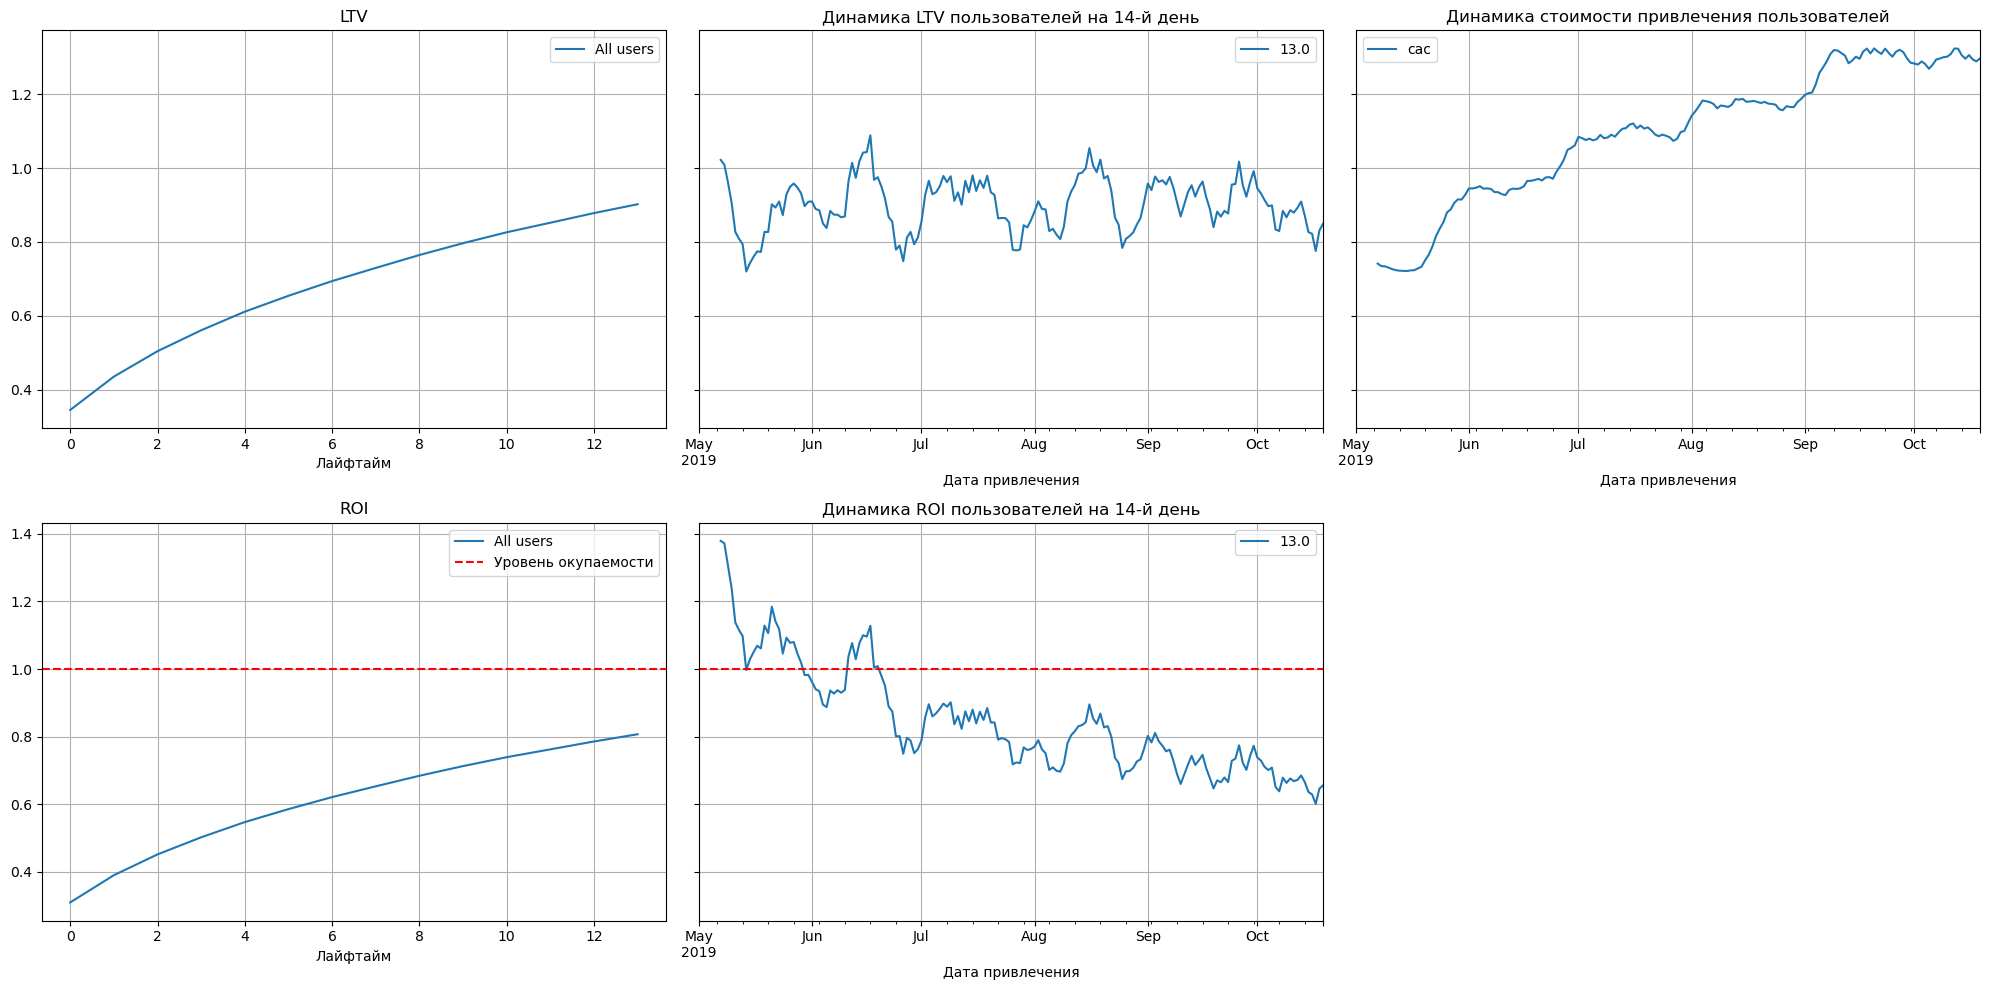

In [43]:
observation_date = datetime(2019, 11, 1).date()  # задаем момент анализа
horizon_days = 14  # задаем горизонт анализа 
# удалим из профилей всех пользователей из канала 'organic', поскольку на них не расходуется рекламный бюджет
profiles = profiles.query('channel!="organic"')
# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)
# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

Судя по графикам, можно сделать следующие выводы:
- LTV равномерно растет с каждым днем, здесь проблем нет, общая сумма денег, которую один клиент в среднем приносит компании со всех своих покупок увеличивается;
- Динамика LTV также не вызывает вопросов. Здесь наблюдается сезонные колебания, но в среднем LTV держится на одном уровне;
- А вот динамика стоимости привлечения пользователей вызывает вопросы: она стабильно растет с каждым месяцем;
- ROI не поднимается до уровня окупаемости и достигает только уровня 0,8 к концу второй недели;
- Динамика ROI также показывает ухудшение показателей начиная с июня. До июня ROI держалась выше линии окупаемости инвестиций.

- Проверьте конверсию пользователей и динамику её изменения. То же самое сделайте с удержанием пользователей. Постройте и изучите графики конверсии и удержания.

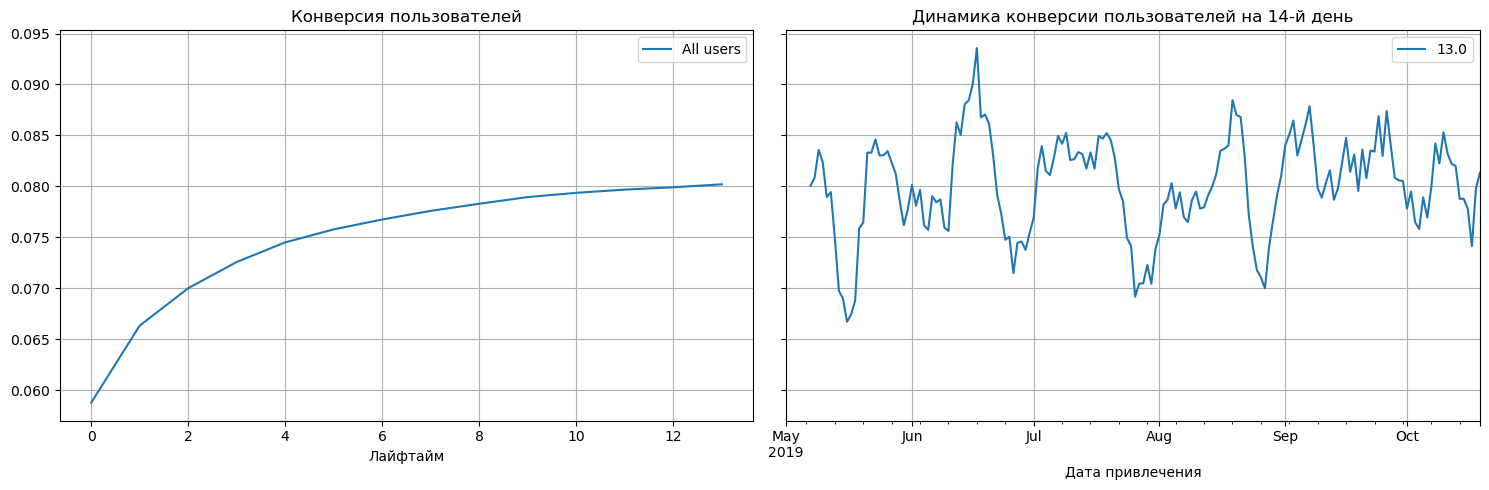

In [44]:
# смотрим конверсию
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days
)
plot_conversion(conversion_grouped, conversion_history, horizon_days)

Кривая конверсии плавно растет от 0 в направлении 1 и не снижается, т.е. пользователи постоянно переходят в категорию покупателей. Что касается динамики конверсии, то она достаточно резко возрастает с июня месяца и после этого ее показатели в среднем равномерны.

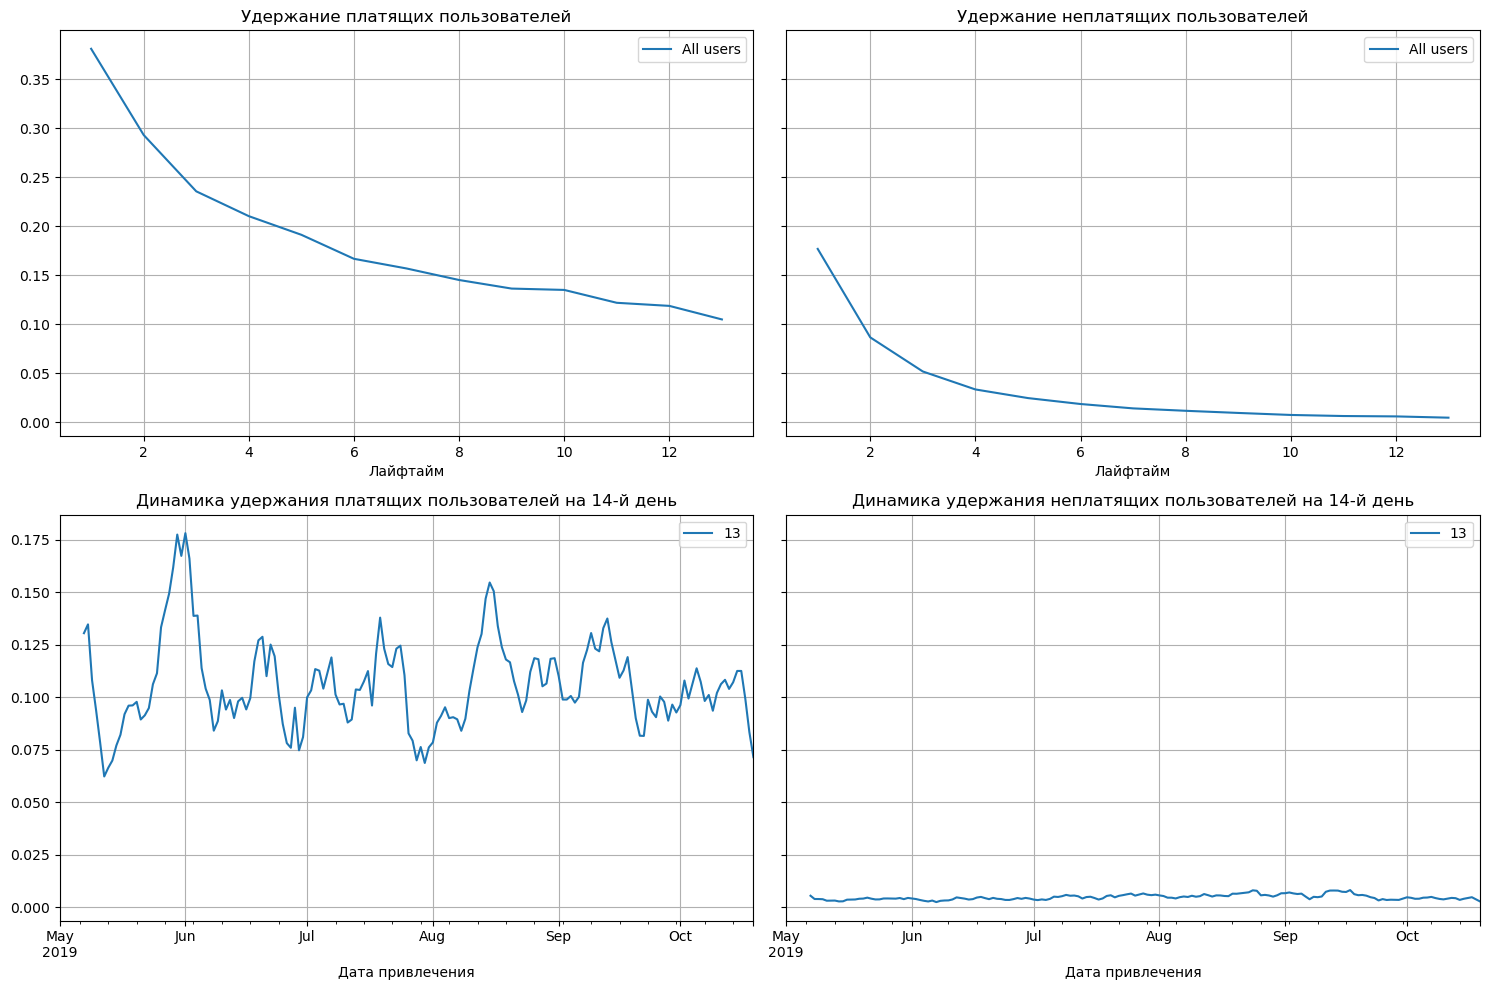

In [45]:
# смотрим удержание
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days
)
plot_retention(retention_grouped, retention_history, horizon_days)

Видно, что удержание убывает по экспоненциальному закону, причем удержание неплатящих убывает быстрее. Но в целом, никаких критических закономерностей не наблюдается.

- Проанализируйте окупаемость рекламы с разбивкой по устройствам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

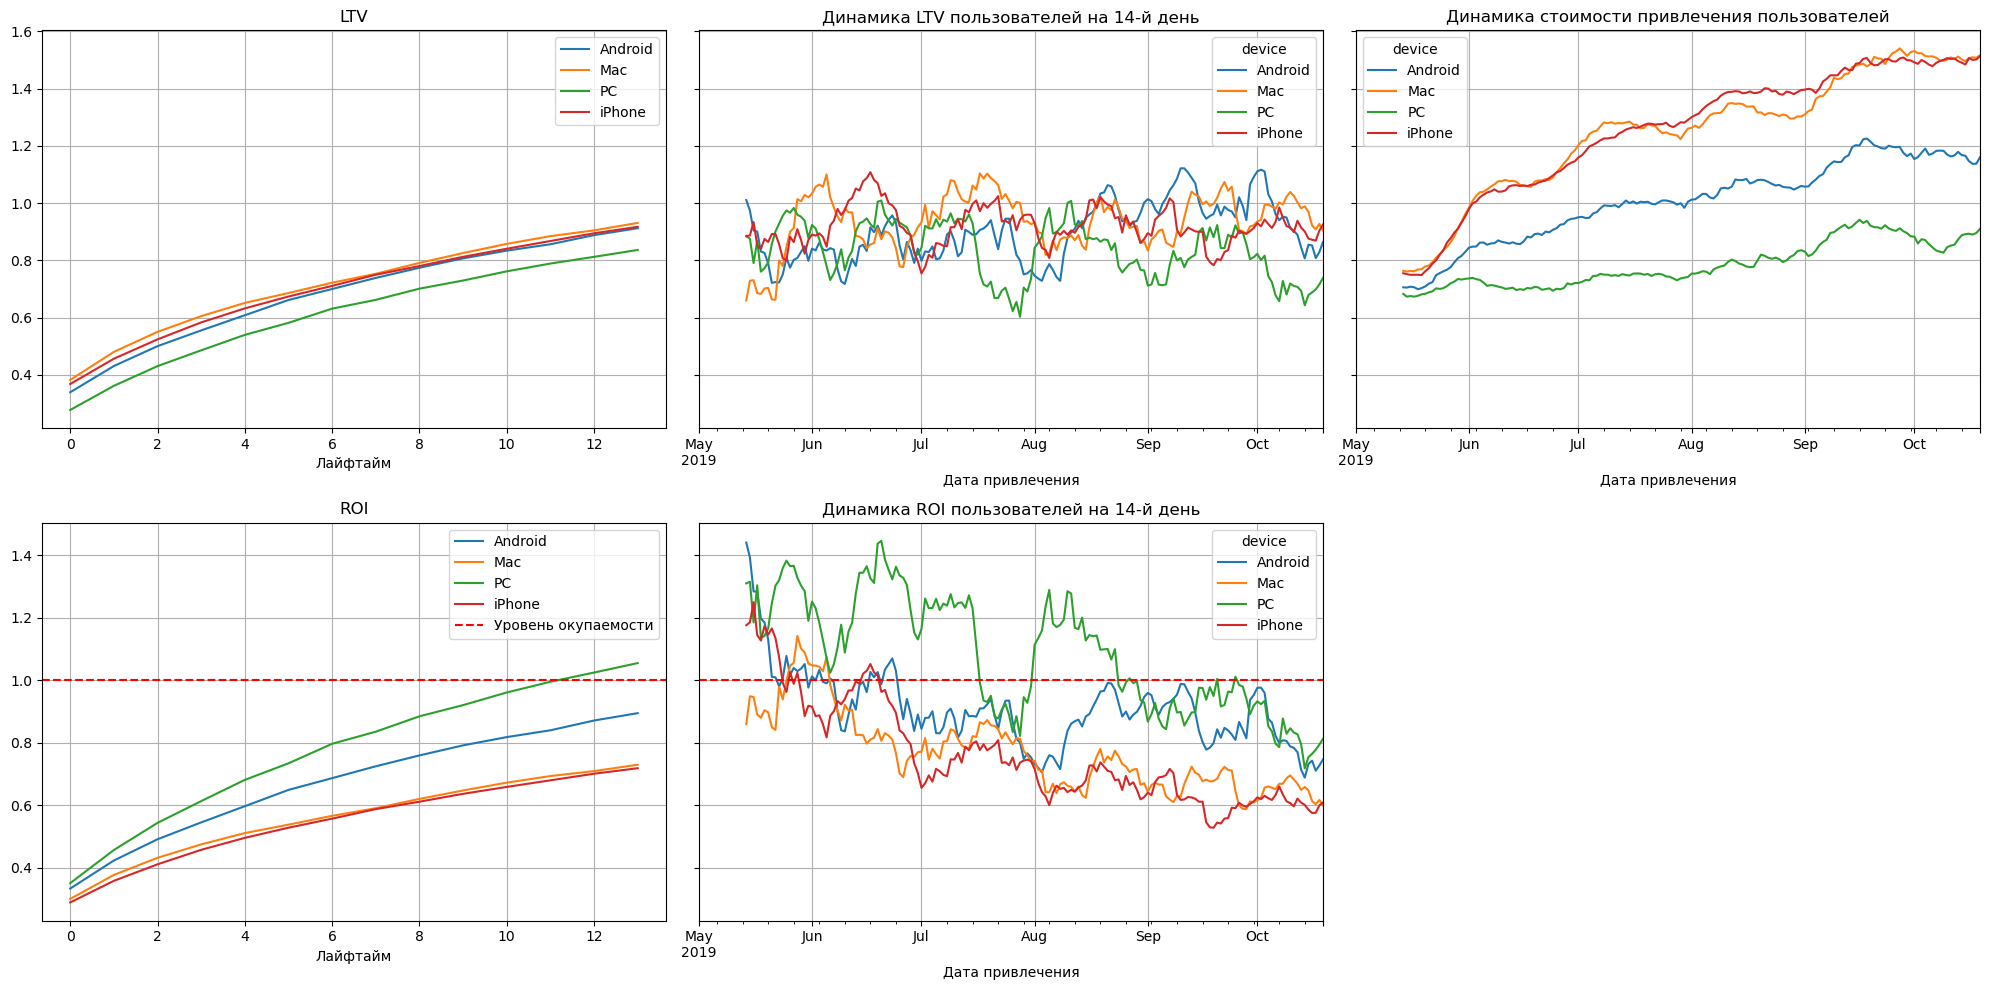

In [46]:
# смотрим окупаемость с разбивкой по устройствам
dimensions = ['device']
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)
plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

Судя по графикам, LTV у PC чуть ниже, чем у остальных устройств. Это же наблюдается и на графике динамики LTV.\
Графики динамики стоимости привлечения пользователей показывают следующую картину: дороже всего обходится привлечение пользователей MAC и IPhone, дешевле всего - пользователи PC. Расходы на привлечение пользователей постоянно увеличиваются.\
Инвестиции в рекламу у PC к 11-му дню окупаются, а вот пользователи других устройств не дотягивают до уровня окупаемости к концу второй недели. \
Наиболее примечателен график динамики ROI. До июня месяца все устройства показывали положительную окупаемость инвестиций с некоторыми колебаниями в отрицательную сторону у пользователей устройств MAC и IPhone. Начиная с июня в положительной области остаются только пользователи PC, тогда как  привлечение пользователей на других устройствах не окупаются. А начиная с сентября в область неокупаемости уходят и пользователи PC.

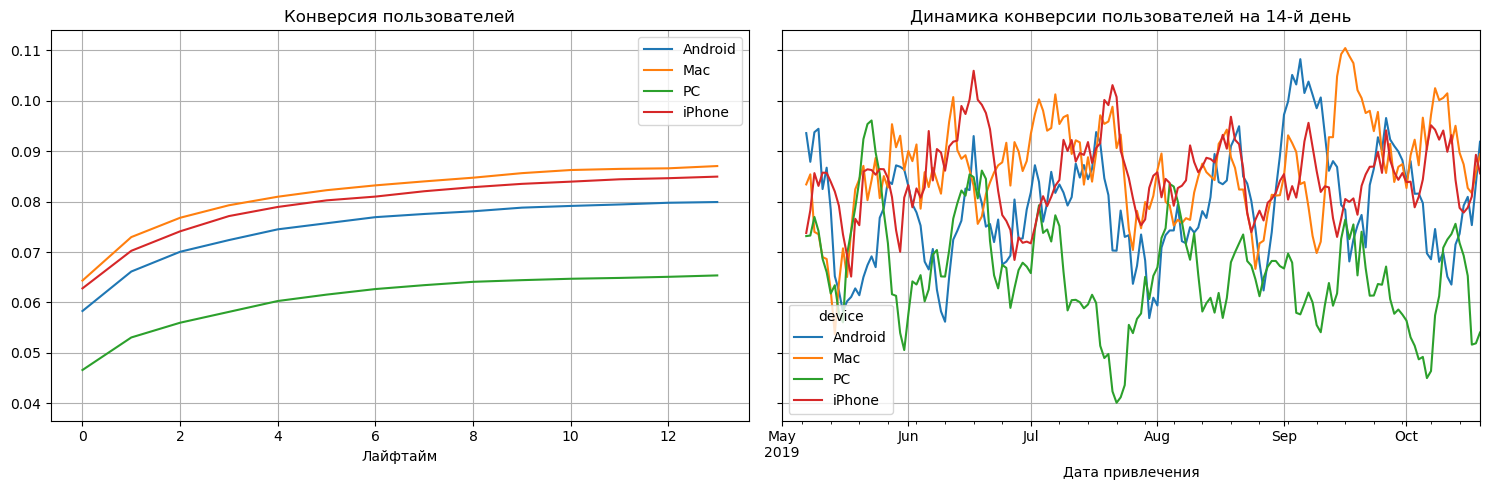

In [47]:
# смотрим конверсию с разбивкой по устройствам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Судя по графикам, пользователи всех устройств конвертируются в покупателей достаточно стабильно, при этом наименьшие показатели у пользователей РС - на графике динамики есть почти нулевые провалы. Наибольшие показатели у Mac и iPhone. На графике динамики конверсии видны сезонные колебания, но в среднем эти колебания компенсируются. 

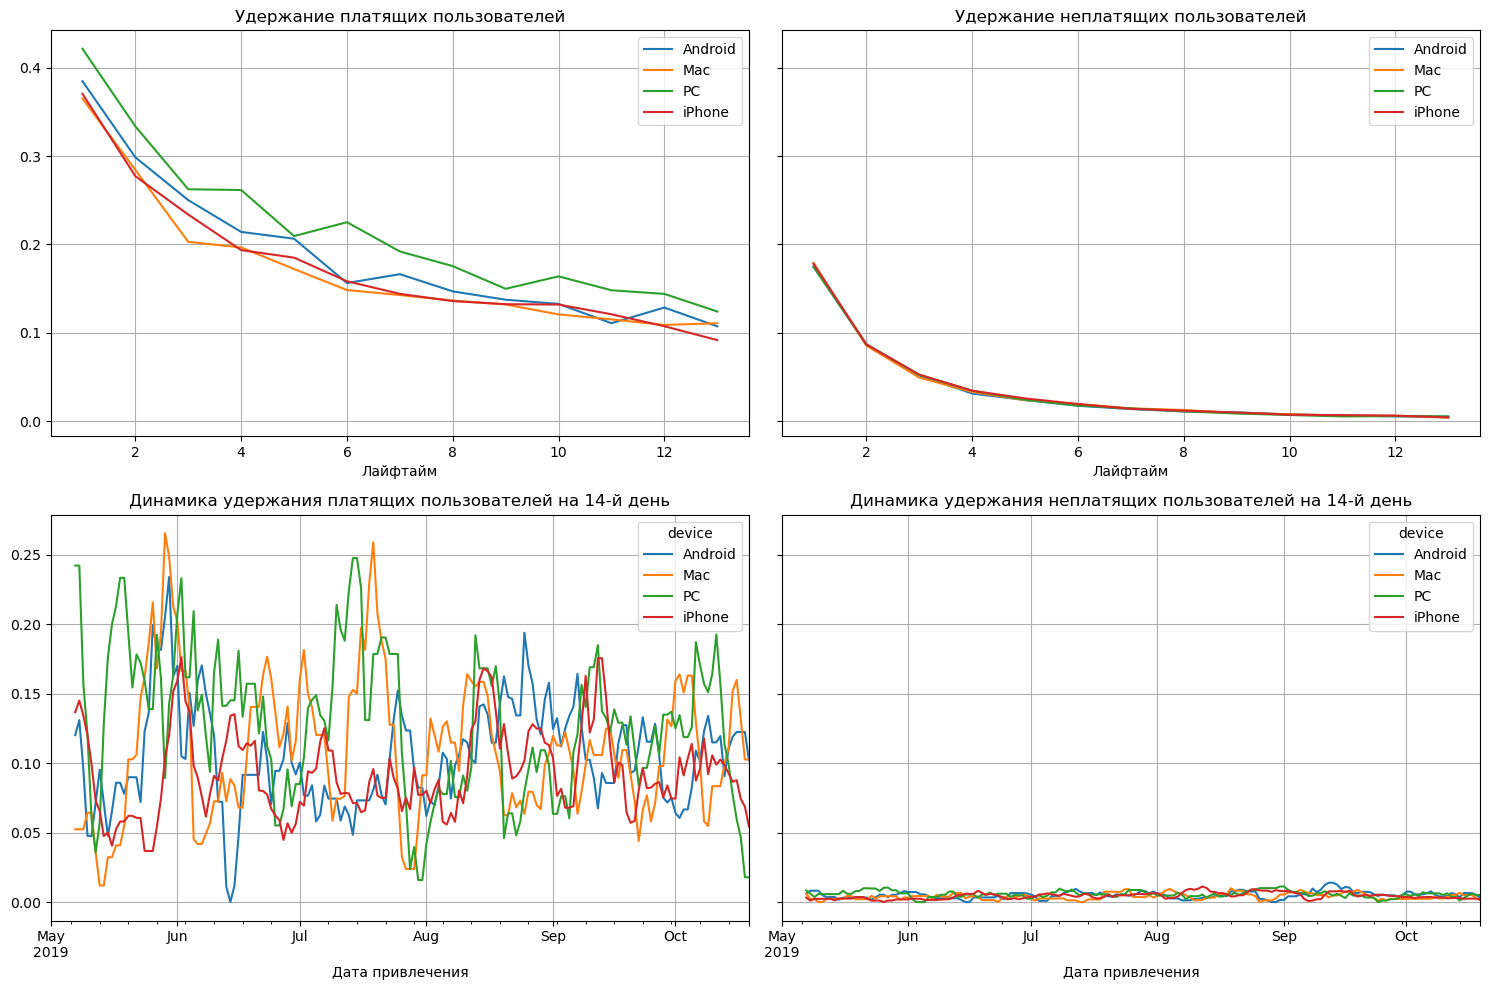

In [48]:
# смотрим удержание с разбивкой по устройствам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Графики удержания не позволяют нам сказать, что пользователи каких-то определенных устройств удерживаются хуже других. Показания достаточно стабильные.

- Проанализируйте окупаемость рекламы с разбивкой по странам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

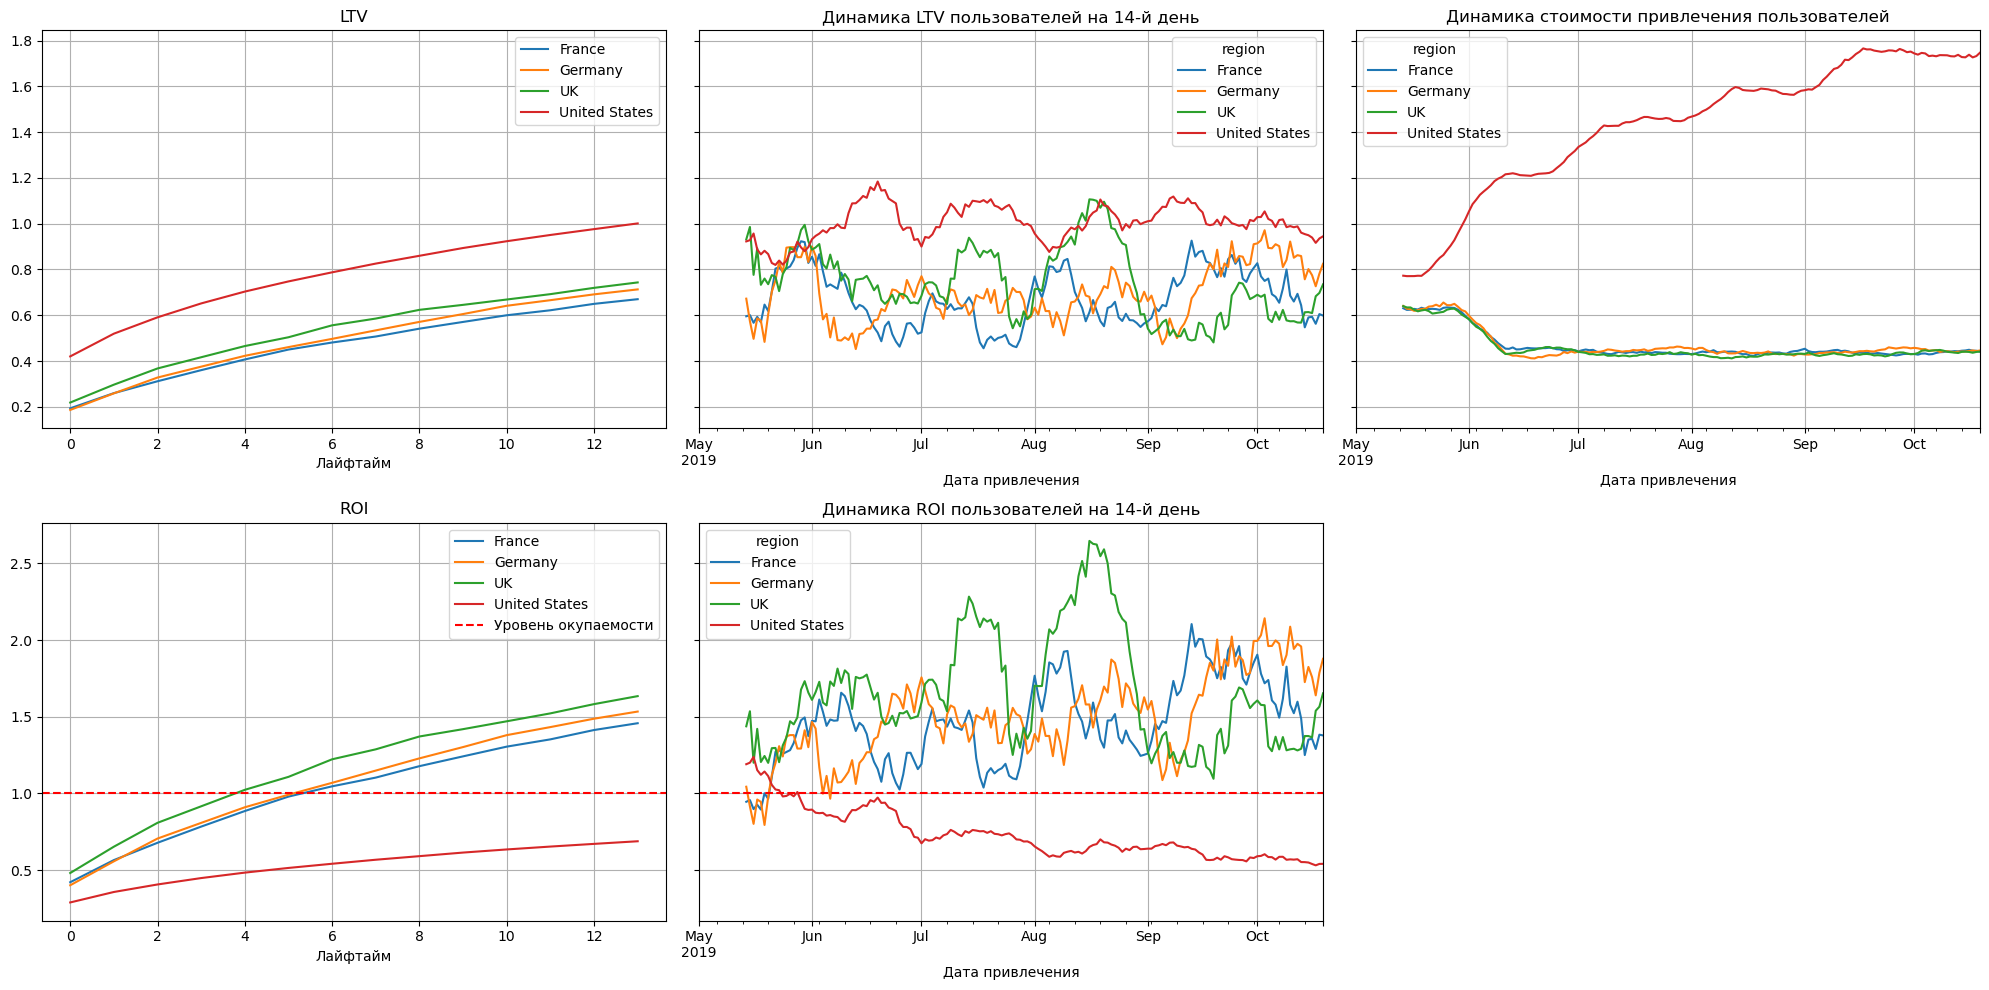

In [49]:
# смотрим окупаемость с разбивкой по странам
dimensions = ['region']
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)
plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

На графиках видно, что самые большие затраты были направлены на привлечение пользователей из США. На графике LTV наблюдаем, что пользователи из США в среднем приносят больше средств, чем пользователи из других стран. На графике динамики LTV  видны некоторые колебания, но в целом средние значения достаточно стабильны.\
При этом график ROI говорит о том, что инвестиции в пользователей США не окупаются, тогда как пользователи из Великобритании, Германии и Франции окупаются уже к концу первой недели. Динамика окупаемости инвестиций показывает отрицательный рост ROI у пользователей из США с мая по октябрь. Тогда как пользователи из остальных стран постоянно находятся в положительной зоне окупаемости.

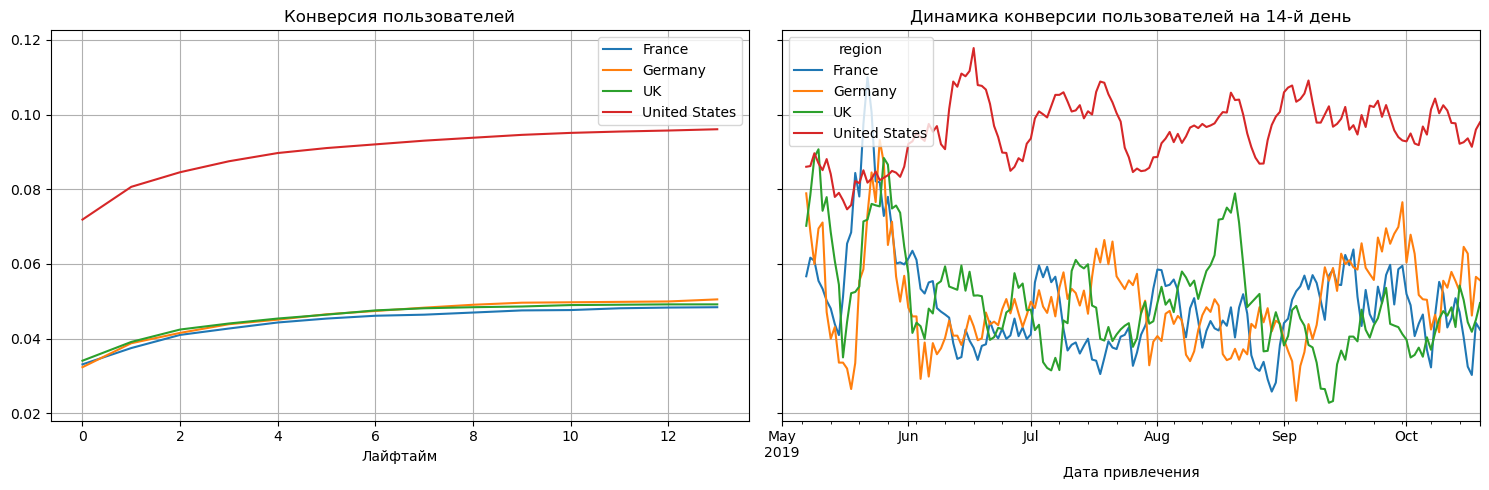

In [50]:
# смотрим конверсию с разбивкой по странам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Здесь явно выделяется линия пользователей из США. Их больше и значение конверсии выше, чем у пользователей из других стран. Это же видно и на графике динамики, хотя в определенный период (мае-июне) конверсия пользователей из всех стран была примерно на одном уровне.

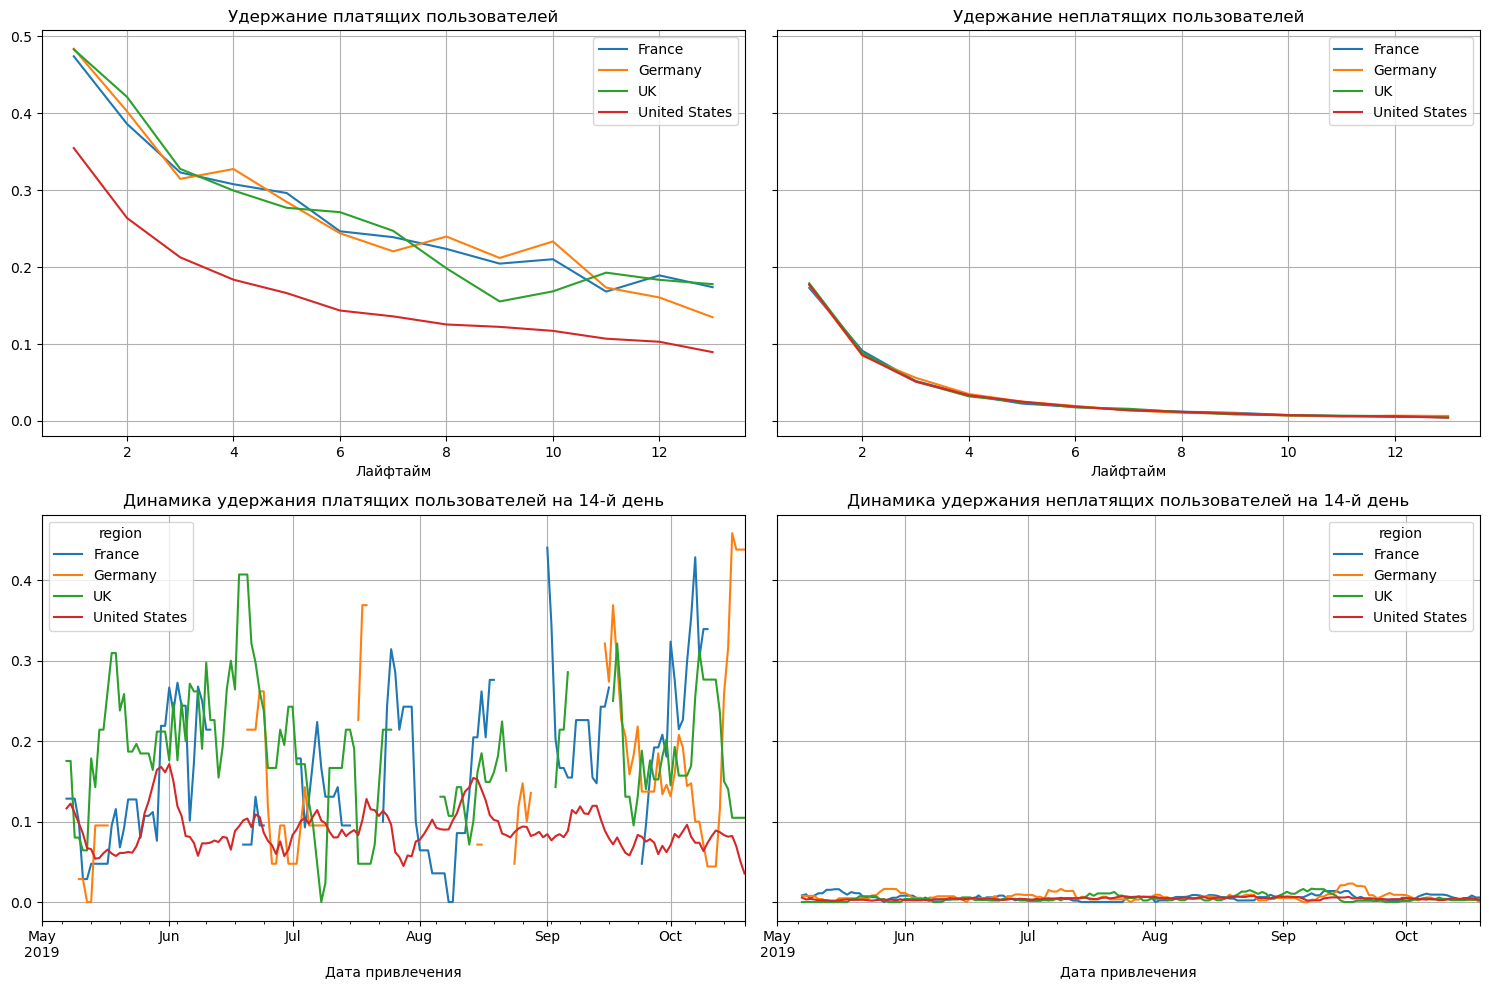

In [51]:
# смотрим удержание с разбивкой по странам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

А вот на графике удержания видно, что пользователи из США удерживаются значительно хуже пользователей из других стран. Еще раз утверждаемся в мысли, что необходимо анализировать более подробно рекламную кампанию, направленную на американских пользователей.

- Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

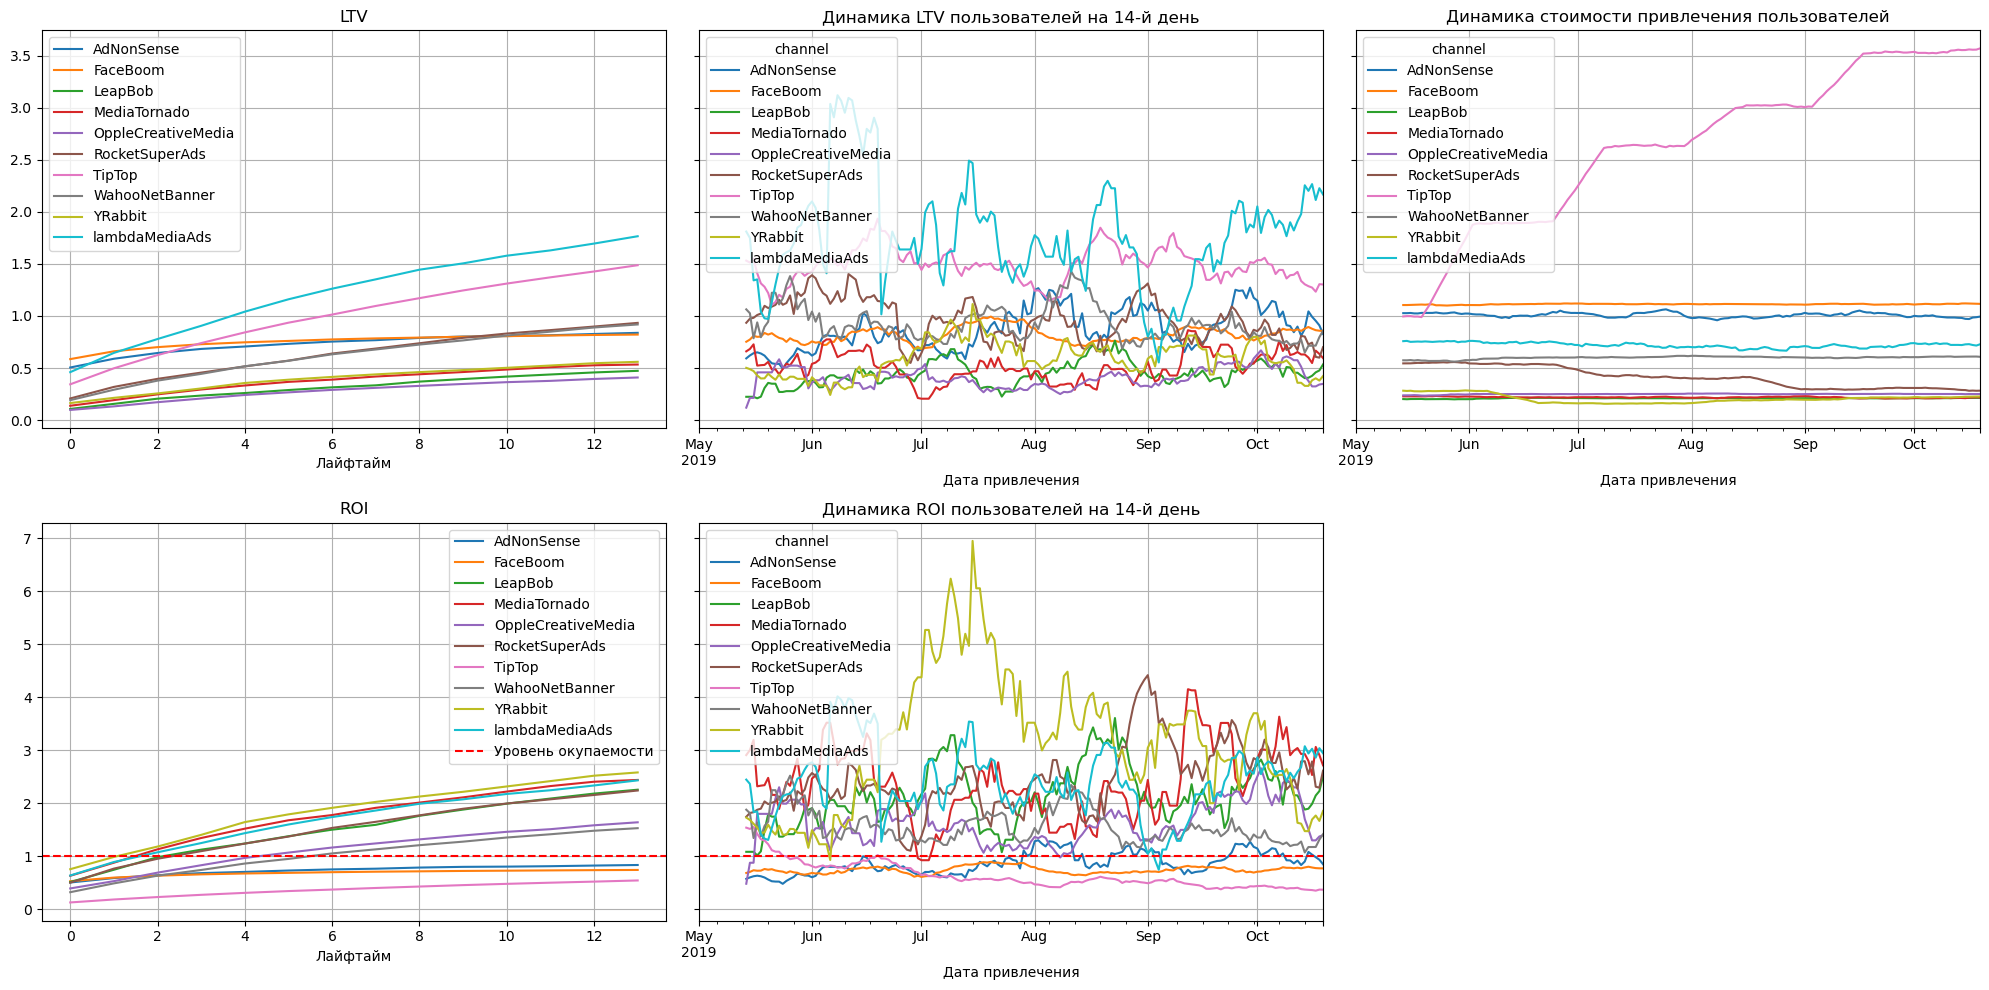

In [52]:
# смотрим окупаемость с разбивкой по рекламным каналам
dimensions = ['channel']
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)
plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

Судя по графику LTV и графику динамики LTV больше всего средств приносят пользователи из каналов lambdaMediaAds и TipTop. На графике САС виден резкий рост стоимости привлечения пользователей из канала TipTop. При этом инвестиции в этот канал не окупаются к концу второй недели. Также отрицательные показатели ROI характерны и для каналов AdNoneSense и FaceBoom. А вот все остальные каналы показывают положительную окупаемость уже на первой неделе. Особенно хорошие показатели ROI были у канала YRabbit в июле-августе.

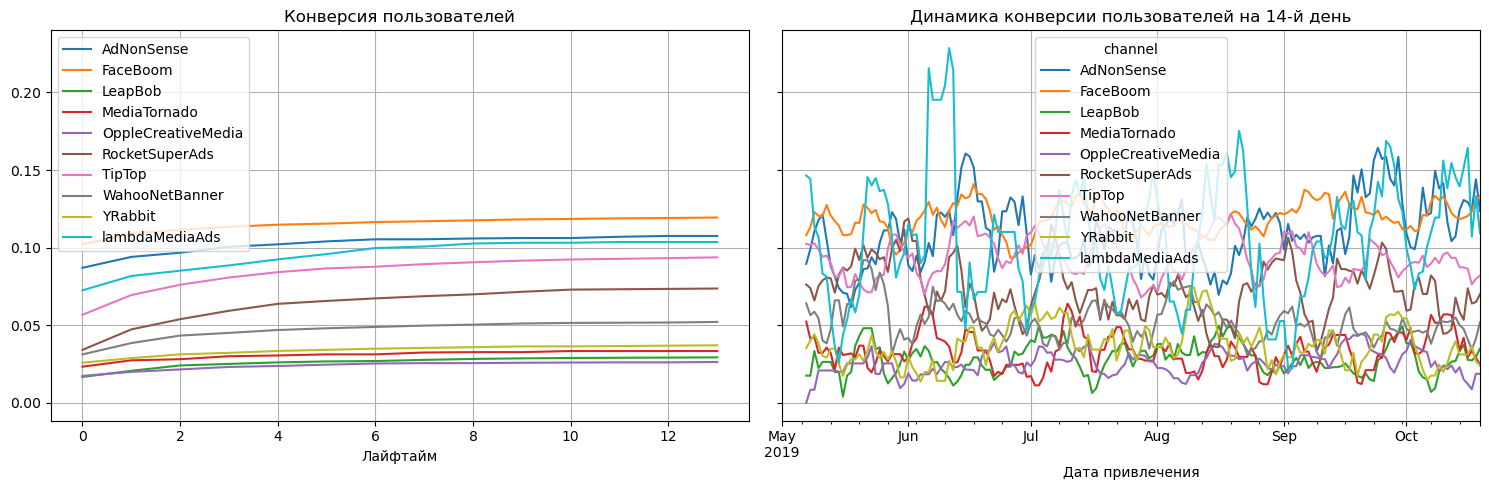

In [53]:
# смотрим конверсию с разбивкой по рекламным каналам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Выше всего показатели конверсии у пользователей FaceBoom, AdNoneSense и lambdaMediaAds, а хуже всего конвертируются пользователи, пришедшие с каналов LeapBob, MediaTornado, OppleCreativeMedia. 

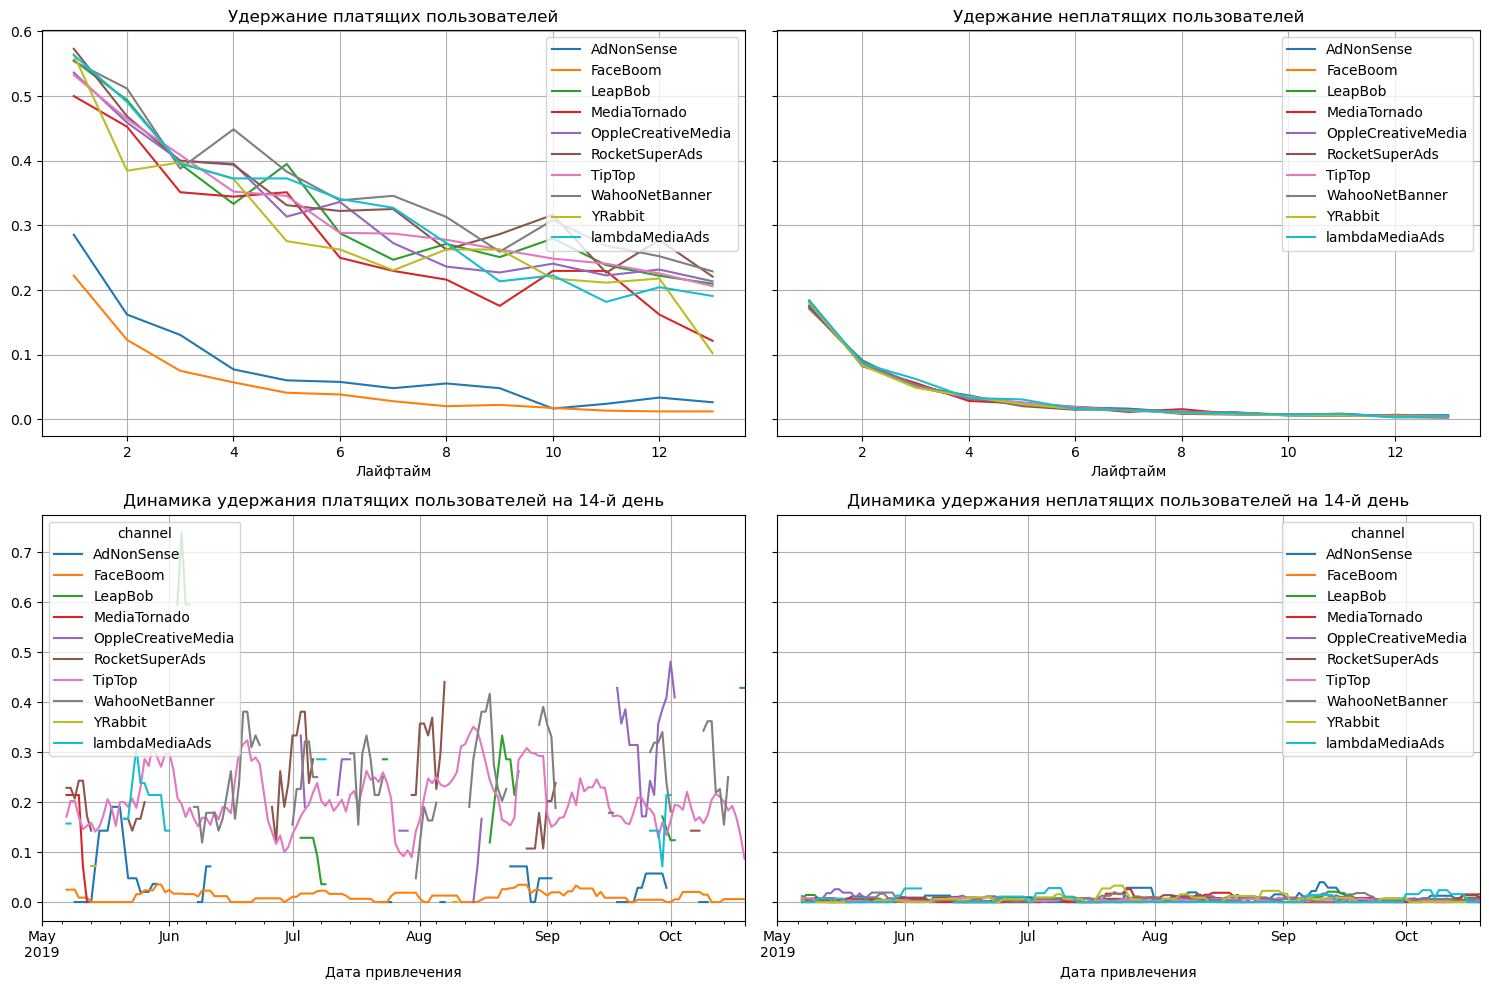

In [54]:
# смотрим удержание с разбивкой по рекламным каналам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Хуже всего удерживаются пользователи, пришедшие из каналов FaceBoom и AdNonSense. У всех остальных каналов удержание в среднем одинаковое.

Ответьте на такие вопросы:
- Окупается ли реклама, направленная на привлечение пользователей в целом?
- Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
- Чем могут быть вызваны проблемы окупаемости?\
Напишите вывод, опишите возможные причины обнаруженных проблем и промежуточные рекомендации для рекламного отдела.

Таким образом, в целом, к концу второй недели инвестиции в рекламное продвижение не окупаются. При этом показатели по разным устройствам, странам и рекламным каналам отличаются.\
Хуже всего окупаются пользователи устройств MAC и IPhone, также негативный вклад в окупаемость оказываются пользователи из США. Что касается рекламных каналов продвижения, то здесь хуже всего окупается каналы TipTop, AdNoneSense и FaceBoom.\
Можно предположить, что основная проблема с окупаемостью связана с неправильным распределением средств по каналам продвижения - большие средства вкладываются в один канал, который плохо работает с нашей целевой аудиторией.\
Следует обратить внимание на владельцев устройств MAC и IPhone - возможно у них возникают технические проблемы (например, с работой приложения на данной операционной системой). Кроме того, особое внимание нужно уделить пользователям из США (это большая часть нашей целевой аудитории) - возможно, изучить другие каналы привлечения и удержания американских пользователей. Следует также расширить каналы работы с пользователями из других стран, которые стабильно окупаются. \
Также необходимо более равномерно распределять рекламные средства по каналам продвижения, особенно акцентируя внимание на те из них, которые показали хорошие результаты по окупаемости (например, каналы YRabbit или lambdaMediaAd).

### Напишите выводы

- Выделите причины неэффективности привлечения пользователей.

Таким образом, мы проанализировали данные по расходам на маркетинговое продвижение приложения Procrastinate Pro+. Несмотря на большие вложения в рекламу, последние несколько месяцев компания терпит убытки. Основная задача, стоявшая перед нами — разобраться в причинах и разработать рекомендации по выходу из кризиса.\
После предварительной обработки данных, была построена таблица профилей, а также определены максимальная и минимальная даты привлечения пользователей - 27.10.2019 и 01.05.2019 соответственно (что полностью соответствует нашему ТЗ).\
Проведя анализ общего количества пользователей в разбивке по странам, увидели, что подавляющая часть пользователей - из США(более 100тысяч), примерно по 17 тысяч пользователей из Великобритании и Франции, и около 15 тысяч проживают в Германии. Порядок доли платящих при этом несколько другой - США, Германия занимают два первых места (6,9%, 4,1%), тогда как Великобритания стоит на третьем месте (4%), а Франция - на 4-ом (3,8%).\
Больше всего клиентов исследуемого приложения используют устройства iPhone и Android, тогда как порядок доли платящих клиентов выглядит так : Mac (6.4%), iPhone (6,2%), Android (5,9%), PC (5%). \
Что касается каналов привлечения клиентов, то больше всего пользователей с большим отрывом приходят из каналов organic, FaceBoom и TipTop, тогда как платящих пользователей в процентном отношении больше всего приносят каналы FaceBoom (12,2%), AdNonSense (11,3%),  lambdaMediaAds (10,5%) и TipTop (9,6%).\
Анализ окупаемости рекламы\
LTV и его динамика растет, также как и конверсия пользователей в покупатели. Т.е. качество пользователей удовлетворительное. А вот динамика стоимости привлечения пользователей вызывает вопросы: она стабильно растет с каждым месяцем, причем достаточно резко. В среднем, реклама к 14 дню не окупается, ROI находится на уровне 80%. При этом динамика окупаемости инвестиций резко ухудшается после июня месяца. Соответственно возникает вопрос о том, не могло ли какое-то событие, произошедшее в июне, повлиять не снижение прибыльности приложения (обновление, выход нового конкурентного родукта на рынок?).\
Анализ окупаемости рекламы с разбивной по устройствам показал самые низкие показатели ROI у пользователей MAC и IPhone - возможно на определенном этапе у них возникают технические неполадки. В то же время, стоимость привлечения пользователей из этих двух сегментов как раз самая высокая. Пользователи всех устройств конвертируются в покупателей достаточно стабильно, при этом наименьшие показатели у пользователей РС - на графике динамики есть почти нулевые провалы. Наибольшие показатели у Mac и iPhone.\
Проанализировав окупаемость в зависимости от региона, можно сделать вывод, что в целом не окупаются пользователи из США, тогда как пользователи из Великобритании, Германии и Франции стабильно показывают положительную окупаемость. При этом инвестиции в американских пользователей максимальны, но здесь это скорее закономерность, поскольку пользователей из США в общей сложности более 65%. При этом показатели конверсии для пользователей максимальные по сравнению с другими странами. А вот на графике удержания видно, что пользователи из США удерживаются значительно хуже пользователей из других стран. Еще раз утверждаемся в мысли, что необходимо анализировать более подробно рекламную кампанию, направленную на американских пользователей.Окупаемость пользователей из США падает, начиная с июня. Стоит разобраться, возможно, произошло какое-то негативное для нашего приложения событие. \
Анализ окупаемости рекламы с разбивкой по каналам привлечения показал проблемы окупаемости по трем каналам: TipTop, AdNoneSense и FaceBoom. При этом САС у канала TipTop резко растет, тогда как ивестиции в этот канал не окупаются к концу второй недели. Таким образом, канал TipTop оказался недостаточно эффективным для целевой аудитории и большие маркетинговые вложения в него нецелесообразны. Что касается конверсии и удержания, выше всего показатели конверсии у пользователей FaceBoom, AdNoneSense и lambdaMediaAds, при этом пользователи, пришедшие из каналов FaceBoom и AdNonSense, хуже всего удерживаются.


- Сформулируйте рекомендации для отдела маркетинга.

1. Поскольку самые низкие показатели окупаемости у пользователей MAC и IPhone при высоких показателях конверсии, стоит обратить внимание на то, как работает приложение на ОС iOS, не сообщают ли пользователи о каких-либо технических проблемах или ошибках на определенном этапе.
2. Стоит обратить внимание на пользователей PC (у них минимальные значения конверсии) и провести маркетинговые мероприятия, которые бы позволили расширить этот кластер пользователей.
3. Поскольку лучше всего окупаются Великобритания, Германия и Франция, можно продумать рекламные кампании и отобрать рекламные каналы, которые бы увеличили число пользователей из этих стран.
4. Стоит проанализировать причины падения окупаемости у самой большой аудитории - из США. Выяснить, что могло произойти в июне 2019 года, когда стали резко падать основные показатели. На основании выводов разработать пути выхода из кризисной ситуации.
5. Стоит пересмотреть денежные потоки в рекламные каналы. Больше всего средств было направлено на канал TipTop, который не оправдал ожиданий. Стоит присмотреться к каналам с наибольшей окупаемостью: например, каналы YRabbit или lambdaMediaAd. Также стоит проанализировать эффективность двух каналов: FaceBoom, AdNoneSense, у которых показатели конверсии максимальны, но которые хуже всего удерживают платящих пользователей.